In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from math import log10
import scipy.stats as st

pd.set_option('display.max_columns', None)

# Load csv files into dictionary

In [3]:
mypath = 'D:\DONE PROJECTS\datascientist_project'

datasets = {}

num = -1
year = 2021

for root, dirs, files in os.walk(mypath, topdown=False):
    for name in files:
        if '_paid_' in name:
            num += 1
            if num == 2:
                num = 0
                year += 1
            datasets["paid_{}_{}".format(num, year)] = pd.read_csv(os.path.join(root, name))

datasets


{'paid_0_2021':       student_id  minutes_watched  paid_q2_2021
 0            767             0.05             0
 1           1067             0.27             0
 2           1151           122.35             0
 3           1571            77.60             0
 4           2058             0.42             0
 ...          ...              ...           ...
 5329      158745             0.15             0
 5330      158749            10.95             0
 5331      158750             0.37             0
 5332      158754             5.47             0
 5333      158762             0.05             0
 
 [5334 rows x 3 columns],
 'paid_1_2021':       student_id  minutes_watched  paid_q2_2021
 0            516            46.27             1
 1            520            91.18             1
 2            523          1322.25             1
 3            603             8.18             1
 4            608           387.68             1
 ...          ...              ...           ...
 2300      

# Plot 'minutes_watched' distributions

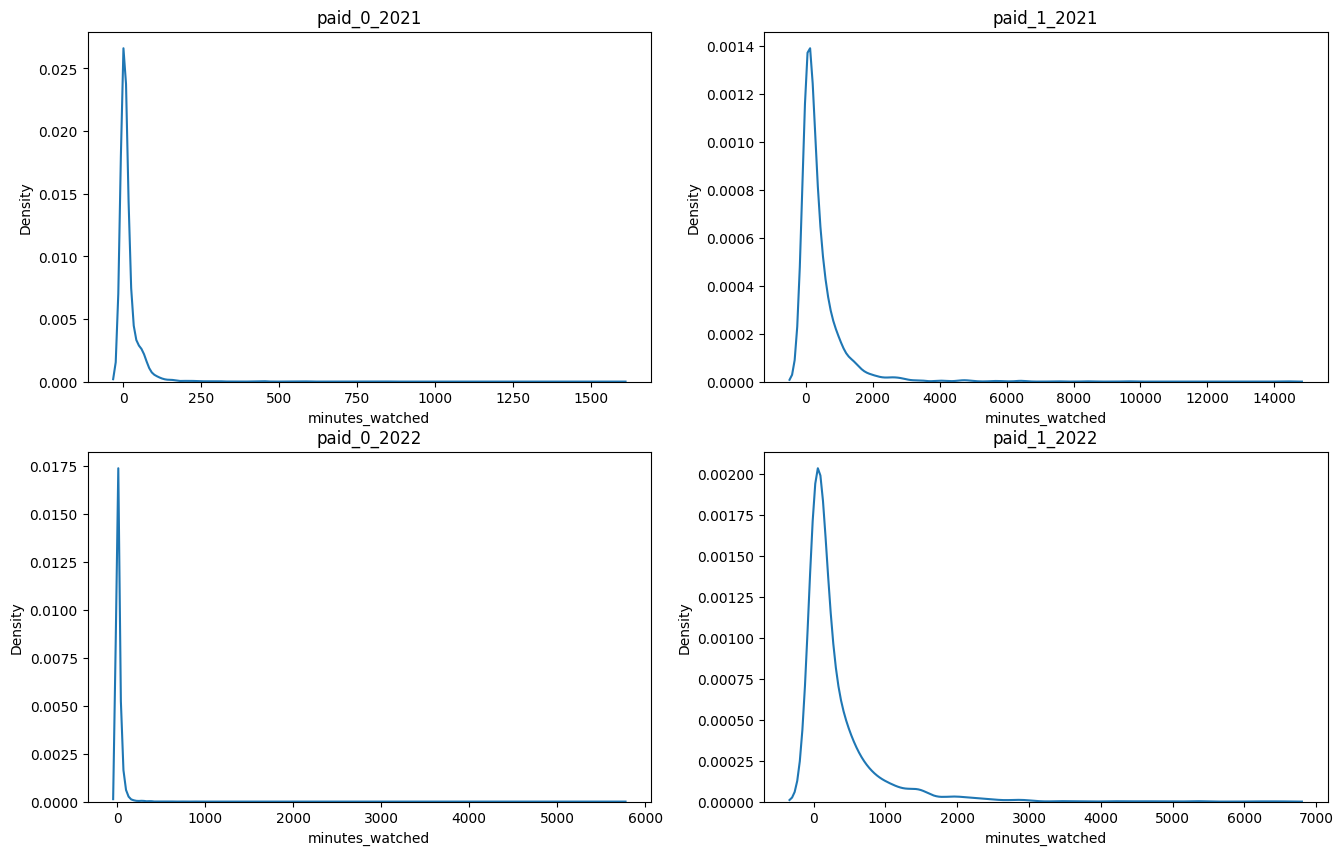

In [4]:
def distributions(datasets: dict) -> plt.axes:
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))

    for (title, df), axes in zip(datasets.items(), ax.ravel()):
        sns.kdeplot(df['minutes_watched'], ax=axes)
        axes.set_title(title)

distributions(datasets)


# Remove outliers, keep the values lower than 99th percentile 

In [5]:
for k, v in datasets.items():
    q99 = v['minutes_watched'].quantile(0.99)
    datasets[k] = v.query("minutes_watched < @q99")
    print(q99)



167.08470000000017
3390.482800000001
170.26300000000015
2505.3450000000003


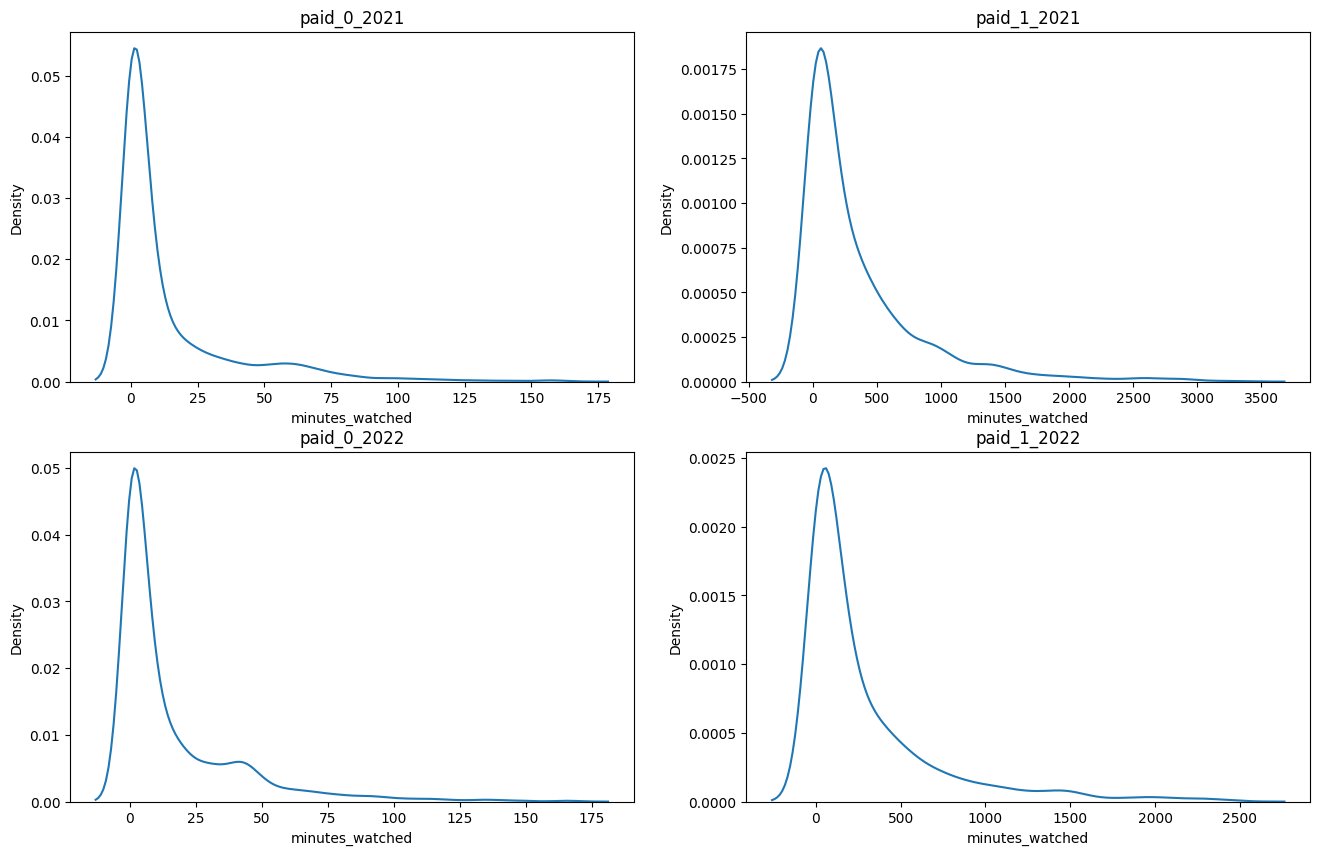

In [6]:
distributions(datasets)

## Compare datasets median to mean and compute 95% confidence interval for each dataset

In [7]:
for k, v in datasets.items():
    mean = v['minutes_watched'].mean().__round__(2)
    median = v['minutes_watched'].median()
    std = v['minutes_watched'].std().__round__(2)
    print('''           {}
median - {}, mean - {}, std - {}'''.format(k, median, mean, std))
    print(st.norm.interval(confidence=0.95, loc=mean, scale=st.sem(v['minutes_watched'])))
    print()

           paid_0_2021
median - 2.79, mean - 14.21, std - 24.48
(13.549788842944238, 14.870211157055763)

           paid_1_2021
median - 161.93, mean - 360.1, std - 499.62
(339.59679095771173, 380.6032090422883)

           paid_0_2022
median - 4.98, mean - 16.04, std - 24.54
(15.418853013343986, 16.66114698665601)

           paid_1_2022
median - 119.75, mean - 292.22, std - 420.19
(276.538338865595, 307.90166113440506)



# Research whether the new features (courses, career tracks, and exams) contribute to the increased number of minutes watched on the platform for free-plan and paying students.



### I am going to conduct Two sample t-test since we need to compare 2 means, also i am going to normalize the datasets because approximately normal distribution is required to conduct the two sample t-test.

In [8]:
paid_0_2021, paid_1_2021, paid_0_2022, paid_1_2022 = (df['minutes_watched'].map(log10) for df in datasets.values())


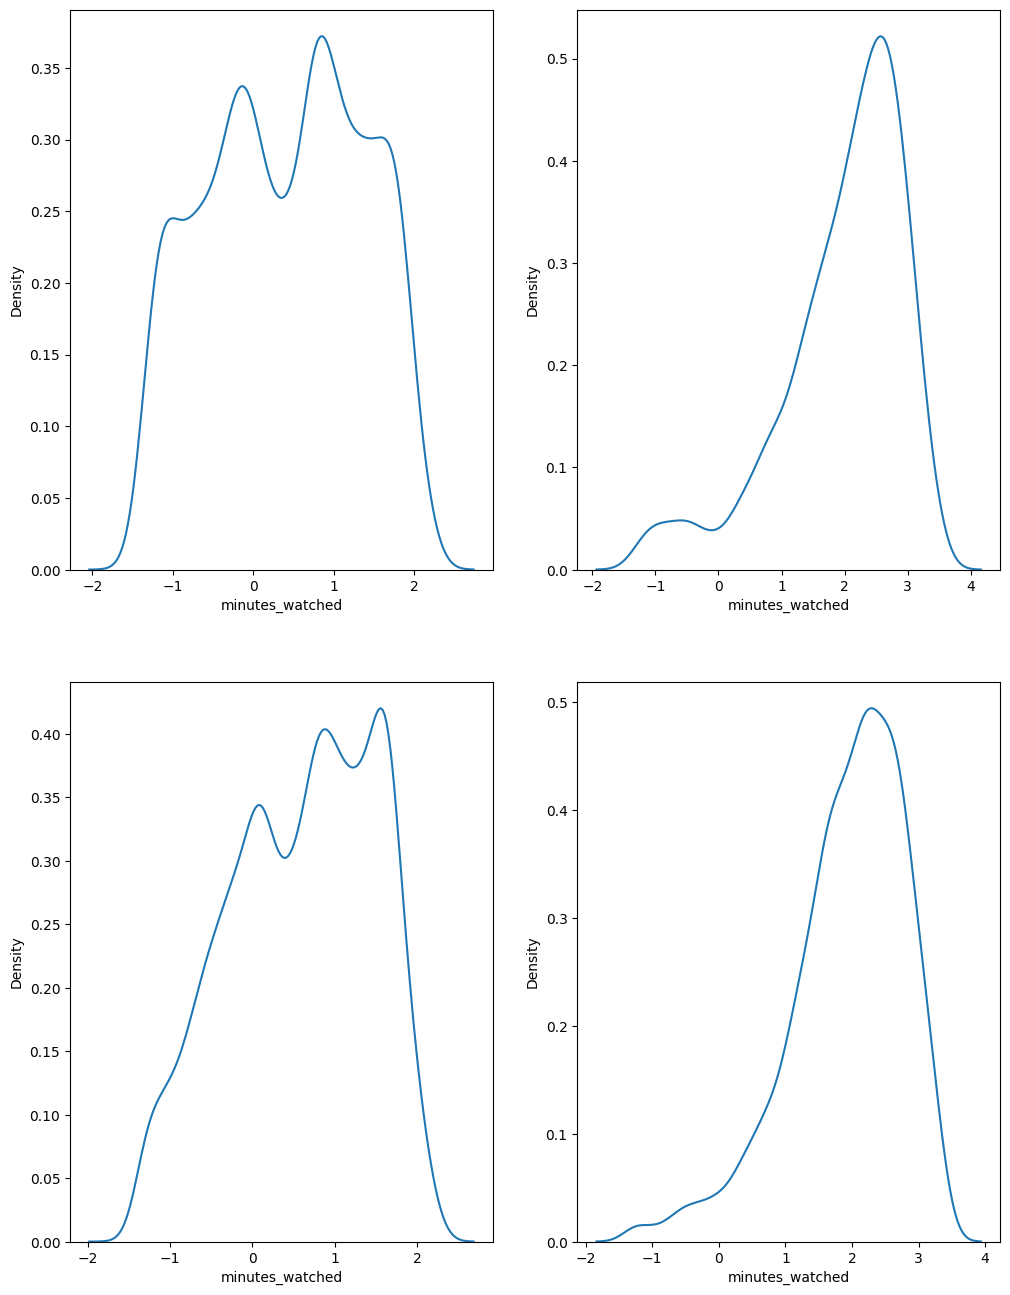

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12, 16))

for df, axes in zip((paid_0_2021, paid_1_2021, paid_0_2022, paid_1_2022), ax.ravel()):
    sns.kdeplot(df, ax=axes)


### * Null Hypothesis: The engagement (minutes watched) in Q2 2021 is equal to the one in Q2 2022 (μ1=μ2). 
### * Alternative Hypothesis: The engagement (minutes watched) in Q2 2021 is not equal than the one in Q2 2022 (μ1!=μ2). 

In [10]:
# Free users
st.ttest_ind(a=paid_0_2021, b=paid_0_2022, equal_var=True)

TtestResult(statistic=-11.319150370153134, pvalue=1.522589058035114e-29, df=11272.0)

### For the free users the computed p-value is lower than 0.05 so we REJECT null hypothesis and assume that engagement in Q2 2021 is not equal to the one in Q2 2022.

In [11]:
# Paid users
st.ttest_ind(a=paid_1_2021, b=paid_1_2022, equal_var=True)

TtestResult(statistic=1.5490364968985781, pvalue=0.12143577061321409, df=5037.0)

### But for the paid users the computed p-value is higher than 0.05 meaning that we FAIL TO REJECT null hypothesis. We assume that the engagement in Q2 2021 is equal to the one in Q2 2022 since we do not have sufficient evidence to say otherwise.